In [1]:
import tensorflow as tf
tf.random.set_seed(0)

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split


from tensorflow import keras
from tensorflow.keras import layers, datasets, models, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import os
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

import random
random.seed(0)

In [2]:
def read_data(filepath):
    dataset = image_dataset_from_directory(
        filepath,
        image_size=(224, 224),
        batch_size=32,
        label_mode='int'
    )
    
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    
    # Chuyển đổi danh sách thành mảng numpy bằng cách dùng np.concatenate
    X = np.concatenate(images, axis=0).astype(np.uint8)
    y = np.concatenate(labels, axis=0).astype(np.uint8)
    
    return X, y

In [3]:
classes = ["apple", "avocado", "banana", "cherry", "kiwi", "mango", "orange", "pinenaple", "strawberries", "watermelon"]
len(classes)

10

In [4]:
X, y = read_data('train')
X_test, y_test = read_data('test')

Found 2301 files belonging to 10 classes.
Found 1025 files belonging to 10 classes.


In [5]:
X.shape, y.shape, X_test.shape, y_test.shape

((2301, 224, 224, 3), (2301,), (1025, 224, 224, 3), (1025,))

In [6]:
X = X.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [7]:
y = keras.utils.to_categorical(y)
y_test = keras.utils.to_categorical(y_test)

In [8]:
# Tạo trình tạo dữ liệu cho ảnh huấn luyện
datagen = ImageDataGenerator(
    rescale=1./255., # Chuyển sang định dạng float
    shear_range=0.2, # Nghiêng ảnh
    zoom_range=0.2, # Phóng to
    horizontal_flip=True, # Lật ngang
    vertical_flip=True, #  Lật dọc
    rotation_range=40
#     width_shift_range=0.2, # Dịch chuyển ngang
#     height_shift_range=0.2, # Dịch chuyển dọc
)

batch = 32
# Tạo trình tạo dữ liệu tăng cường cho ảnh huấn luyện
train_generator = datagen.flow_from_directory(
    directory='train',
    target_size=(224, 224),  # Kích thước ảnh mong muốn
    batch_size=batch,
    class_mode='categorical'  # Chế độ phân loại đa nhãn
)

Found 2301 images belonging to 10 classes.


In [9]:
# Thực hiện tăng cường dữ liệu
X_augmented = []
y_augmented = []
for i in range(63):
    batch_X, batch_y = next(train_generator)
    
    X_augmented.append(batch_X)
    y_augmented.append(batch_y)
X_augmented = np.array(X_augmented).reshape(-1, 224, 224, 3)
y_augmented = np.array(y_augmented).reshape(-1, 10)

In [10]:
X = np.concatenate((X, X_augmented))
y = np.concatenate((y, y_augmented))

In [11]:
X.shape, y.shape

((4317, 224, 224, 3), (4317, 10))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
input_tensor = Input(shape = (224, 224, 3))
x = Conv2D(32, 3, activation = 'relu')(input_tensor)
x = Conv2D(32, 3, activation = 'relu')(x)
# x = Dropout(0.5)(x)


x = MaxPooling2D(2)(x)
x = Flatten()(x)

# FC
x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)?
x = Dense(10, activation='softmax')(x)

model = models.Model(inputs = input_tensor, outputs = x)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 387200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      49,561,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,573,162 (189.11 MB)

 Trainable params: 49,573,162 (189.11 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
H = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 32, epochs = 10, verbose=1)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 92s 783ms/step - accuracy: 0.1251 - loss: 8.5674 - val_accuracy: 0.3218 - val_loss: 1.9065
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 79s 731ms/step - accuracy: 0.3063 - loss: 1.8506 - val_accuracy: 0.3600 - val_loss: 1.7155
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 79s 733ms/step - accuracy: 0.5223 - loss: 1.4206 - val_accuracy: 0.3449 - val_loss: 1.8902
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 78s 726ms/step - accuracy: 0.7517 - loss: 0.8243 - val_accuracy: 0.3495 - val_loss: 2.3204
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 81s 755ms/step - accuracy: 0.9131 - loss: 0.3609 - val_accuracy: 0.3044 - val_loss: 3.2611
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 84s 781ms/step - accuracy: 0.9618 - loss: 0.1966 - val_accuracy: 0.2697 - val_loss: 3.9845
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 757ms/step - accuracy: 0.9817 - loss: 0.1013 - val_accuracy: 0.3264 - val_loss: 3.7358
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 73s 677ms/step - accuracy: 0.9951 - loss: 0

In [17]:
score = model.evaluate(X_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.3368 - loss: 3.9261


In [18]:
score

[3.861703872680664, 0.34536585211753845]

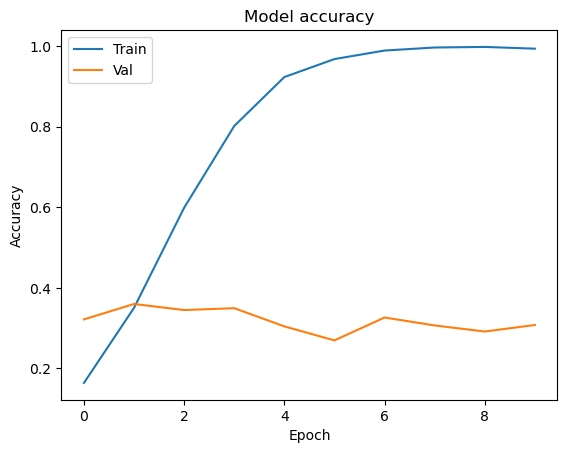

In [19]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()